In [68]:
import numpy as np
import pandas as pd
import os

In [124]:
data = pd.read_csv('shoes_v3.csv', index_col=0)
data[['CID', 'Url']].head()

,CID,Url
0,100627-72,Shoes/Oxfords/Bostonian/100627.72.jpg
1,100627-255,Shoes/Oxfords/Bostonian/100627.255.jpg
2,100657-72,Shoes/Oxfords/Bostonian/100657.72.jpg
3,100657-216,Shoes/Oxfords/Bostonian/100657.216.jpg
4,101026-3,Boots/Mid-Calf/Durango/101026.3.jpg


In [125]:
# color groups generated from CSS3 webcolors
colors = pd.read_csv('colors.csv', index_col=0)
colors.head()

,color,group,hex,r,g,b
0,peachpuff,yellow,#ffdab9,255,218,185
1,linen,white,#faf0e6,250,240,230
2,honeydew,white,#f0fff0,240,255,240
3,cornsilk,brown,#fff8dc,255,248,220
4,mistyrose,white,#ffe4e1,255,228,225


In [126]:
def get_color_name(rgb):
    dists = ((colors[['r', 'g', 'b']] - rgb)**2).sum(axis=1)
    return tuple(colors.loc[dists.idxmin(), ['color', 'group']].values)

color = (119, 172, 152)
name = get_color_name(color)

print(name)

('cadetblue', 'blue')


array(['brown', 'white'], dtype=object)

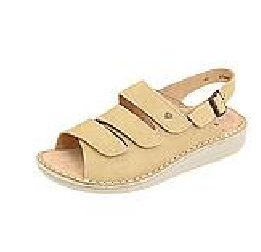

In [127]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import argparse
import cv2

images_folder = 'images'

def extract_colors(url, n_colors=5, plot=False):
    image = cv2.imread(os.path.join(images_folder, url))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if plot:
        plt.figure()
        plt.axis("off")
        plt.imshow(image)
    
    image = pd.DataFrame(image.reshape((image.shape[0] * image.shape[1], 3)))
    image = image[image.sum(axis=1) < 255 * 3]
    clt = KMeans(n_clusters=n_colors)
    clt.fit(image)
    
    num_labels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=num_labels)

    hist = hist.astype("float")
    hist /= hist.sum()
    colors = [get_color_name(color) for color in clt.cluster_centers_]
    colors = [c[1] for c in colors]
    
    im_colors = pd.DataFrame({'color': colors, 'perc': hist}).groupby('color').sum()
    im_colors = im_colors.sort_values('perc', ascending=False)
    im_colors = im_colors[im_colors['perc'] > 0.2]
    
    return im_colors.index[:2].values

extract_colors(data.iloc[444]['Url'], plot=True)

array(['grey'], dtype=object)

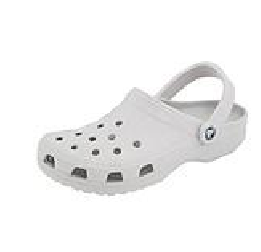

In [128]:
extract_colors(data.loc[10256, 'Url'], plot=True)

array(['brown', 'white'], dtype=object)

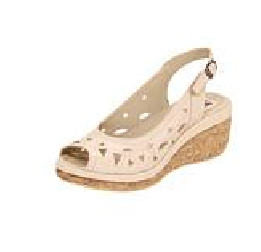

In [129]:
extract_colors(data.loc[65000, 'Url'], plot=True)

array(['white', 'brown'], dtype=object)

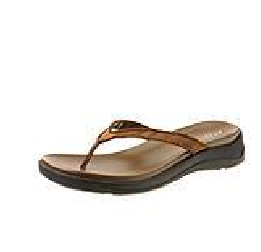

In [130]:
extract_colors(data.loc[2729, 'Url'], plot=True)

array(['white', 'green'], dtype=object)

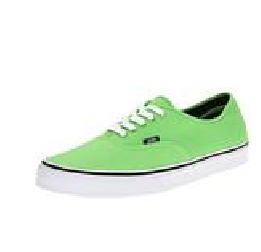

In [131]:
extract_colors(data.loc[18945, 'Url'], plot=True)

In [132]:
urls = data['Url'].drop_duplicates()
url_colors = pd.DataFrame({'Url': urls, 'Color': urls.apply(extract_colors)})
url_colors.head()

,Color,Url
0,[black],Shoes/Oxfords/Bostonian/100627.72.jpg
1,[black],Shoes/Oxfords/Bostonian/100627.255.jpg
2,"[black, white]",Shoes/Oxfords/Bostonian/100657.72.jpg
3,"[brown, grey]",Shoes/Oxfords/Bostonian/100657.216.jpg
4,"[black, white]",Boots/Mid-Calf/Durango/101026.3.jpg


In [134]:
data = pd.merge(data, url_colors, on='Url')
data.to_csv('shoes_v4.csv')

In [135]:
data.head()

,Unnamed: 0.1,CID,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle,Brand,Url,unique_Closure,unique_Gender,unique_Material,Color
0,0,100627-72,Shoes,Oxfords,NaN,Leather,['Lace up'],['Men'],['Leather'],Capped Toe;Round Toe,Bostonian,Shoes/Oxfords/Bostonian/100627.72.jpg,Lace up,Men,Leather,[black]
1,1,100627-255,Shoes,Oxfords,NaN,Leather,['Lace up'],['Men'],['Leather'],Capped Toe;Round Toe,Bostonian,Shoes/Oxfords/Bostonian/100627.255.jpg,Lace up,Men,Leather,[black]
2,2,100657-72,Shoes,Oxfords,NaN,Leather;Padded;Removable,['Lace up'],['Men'],['Leather'],Capped Toe;Round Toe,Bostonian,Shoes/Oxfords/Bostonian/100657.72.jpg,Lace up,Men,Leather,"[black, white]"
3,3,100657-216,Shoes,Oxfords,NaN,Leather;Padded;Removable,['Lace up'],['Men'],['Leather'],Capped Toe;Round Toe,Bostonian,Shoes/Oxfords/Bostonian/100657.216.jpg,Lace up,Men,Leather,"[brown, grey]"
4,4,101026-3,Boots,Mid-Calf,1in - 1 3/4in,Leather;Padded,['Pull-on'],['Men'],"['Leather', 'Rubber']",Square Toe;Closed Toe,Durango,Boots/Mid-Calf/Durango/101026.3.jpg,Pull-on,Men,Leather,"[black, white]"
